In [15]:
import numpy as np
from astropy.io import ascii


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

data_decmin, data_decmax = data['_DEJ2000'].min(),data['_DEJ2000'].max()
data_ramin, data_ramax = data['_RAJ2000'].min(),data['_RAJ2000'].max()
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data_decmin,data_decmax))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data_ramin, data_ramax))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))

data.keys()


Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


['_RAJ2000',
 '_DEJ2000',
 'Kcmag',
 'Hcmag',
 'Jcmag',
 'Ktmag',
 'K_abs',
 'type',
 'cz',
 'JNAME',
 'W1mag',
 'W2mag',
 'W3mag',
 'class']

#### Autocorrelation

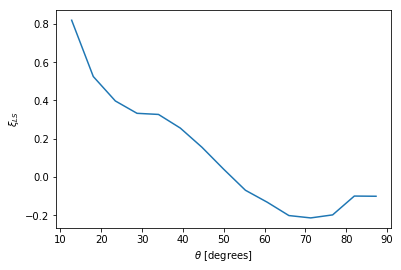

In [70]:
from nbodykit.lab import *

datacat = ArrayCatalog(data)#, names=['_RAJ2000','_DEJ2000','Kcmag','Hcmag','Jcmag','Ktmag','K_abs','type','cz','JNAME','W1mag','W2mag','W3mag','class'])
rancat = RandomCatalog(len(datacat)*10, seed=42)
rancat['_RAJ2000']  = rancat.rng.uniform(low=data_ramin, high=data_ramax)
rancat['_DEJ2000'] = rancat.rng.uniform(low=data_decmin, high=data_decmax)

nbins = 15
bins = np.linspace(10., 90., nbins+1)

r_auto = SurveyData2PCF(mode='angular',data1=datacat, randoms1=rancat, \
                        edges=bins, ra='_RAJ2000', dec='_DEJ2000')




import matplotlib.pyplot as plt

plt.plot(r_auto.corr['theta'],r_auto.corr['corr'])

plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\xi_{LS}$")
plt.show()

#### LS: (DD-2DR+RR)/RR

In [57]:
ls = (r_auto.D1D2['npairs'].astype(np.float)-2.*r_auto.D1R2['npairs']+r_auto.R1R2['npairs'].astype(np.float))\
    /r_auto.R1R2['npairs'].astype(np.float)
print(ls)

print(r_auto.corr['corr'])

[0.86350052 0.84886458 0.83678554 0.82665121 0.82001191 0.81303016
 0.80589137 0.79814701 0.79209664 0.79020249 0.79012245 0.79230684
 0.79647277 0.80154752 0.80470264]
[ 0.81956631  0.52515095  0.3974389   0.33276098  0.32692438  0.25565014
  0.15506648  0.04053001 -0.06958128 -0.13221598 -0.20197666 -0.21432228
 -0.19848736 -0.10000608 -0.10103254]


#### Crosscorrelation

In [75]:
from nbodykit.lab import *

datacat = ArrayCatalog(data)#, names=['_RAJ2000','_DEJ2000','Kcmag','Hcmag','Jcmag','Ktmag','K_abs','type','cz','JNAME','W1mag','W2mag','W3mag','class'])
eventscat = ArrayCatalog(events_a8)#, names=['_RAJ2000','_DEJ2000','Kcmag','Hcmag','Jcmag','Ktmag','K_abs','type','cz','JNAME','W1mag','W2mag','W3mag','class'])

data_decmin, data_decmax = data['_DEJ2000'].min(),data['_DEJ2000'].max()
data_ramin, data_ramax = data['_RAJ2000'].min(),data['_RAJ2000'].max()
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data_decmin,data_decmax))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data_ramin, data_ramax))

eve_decmin, eve_decmax = events_a8['dec'].min(),events_a8['dec'].max()
eve_ramin, eve_ramax = events_a8['RA'].min(),events_a8['RA'].max()
print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (eve_ramin, eve_ramax))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (eve_ramin, eve_ramax))


datacat['RA'] = datacat['_RAJ2000']
datacat['DEC'] = datacat['_DEJ2000']
eventscat['DEC'] = eventscat['dec']

################################################################################

rancat1 = RandomCatalog(len(datacat)*10, seed=42)
rancat1['RA']  = rancat1.rng.uniform(low=data_ramin, high=data_ramax)
rancat1['DEC'] = rancat1.rng.uniform(low=data_decmin, high=data_decmax)


rancat2 = RandomCatalog(len(eventscat)*10, seed=43)
rancat2['RA']  = rancat2.rng.uniform(low=eve_ramin, high=eve_ramax)
rancat2['DEC'] = rancat2.rng.uniform(low=eve_decmin, high=eve_decmax)

nbins = 15
bins = np.linspace(10., 90., nbins+1)

r_cross = SurveyData2PCF(mode='angular',\
                        data1=datacat, randoms1=rancat1,\
                        data2=eventscat, randoms2=rancat1,\
                        edges=bins, ra='RA', dec='DEC')

################################################################################

import matplotlib.pyplot as plt

plt.plot(r_cross.corr['theta'],r_cross.corr['corr'])

plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\xi_{LS}$")
plt.show()

Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range: 0.00deg - 360.00deg
UHECR RA range: 0.00deg - 360.00deg


##### Bright/Faint Crosscorrelation

In [5]:
import numpy as np
from astropy.io import ascii
from nbodykit.lab import *


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

data_decmin, data_decmax = data['_DEJ2000'].min(),data['_DEJ2000'].max()
data_ramin, data_ramax = data['_RAJ2000'].min(),data['_RAJ2000'].max()
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data_decmin,data_decmax))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data_ramin, data_ramax))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))

##################################################################################################

data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

brightcat = ArrayCatalog(data_bright)
faintcat = ArrayCatalog(data_faint)
eventscat = ArrayCatalog(events_a8)

brightcat['RA'] = brightcat['_RAJ2000']
brightcat['DEC'] = brightcat['_DEJ2000']
faintcat['RA'] = faintcat['_RAJ2000']
faintcat['DEC'] = faintcat['_DEJ2000']
eventscat['DEC'] = eventscat['dec']


rancat_b = RandomCatalog(len(brightcat)*10, seed=42)
rancat_b['RA']  = rancat_b.rng.uniform(low=brightcat['RA'].min(), high=brightcat['RA'].max())
rancat_b['DEC'] = rancat_b.rng.uniform(low=brightcat['DEC'].min(), high=brightcat['DEC'].max())


rancat_f = RandomCatalog(len(faintcat)*10, seed=43)
rancat_f['RA']  = rancat_f.rng.uniform(low=faintcat['RA'].min(), high=faintcat['RA'].max())
rancat_f['DEC'] = rancat_f.rng.uniform(low=faintcat['DEC'].min(), high=faintcat['DEC'].max())

#################################################################################################

nbins = 15
bins = np.linspace(10., 90., nbins+1)

r_cross_b = SurveyData2PCF(mode='angular',\
                        data1=brightcat, randoms1=rancat_b,\
                        data2=eventscat, randoms2=rancat_b,\
                        edges=bins, ra='RA', dec='DEC')

r_cross_f = SurveyData2PCF(mode='angular',\
                        data1=faintcat, randoms1=rancat_f,\
                        data2=eventscat, randoms2=rancat_f,\
                        edges=bins, ra='RA', dec='DEC')

Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


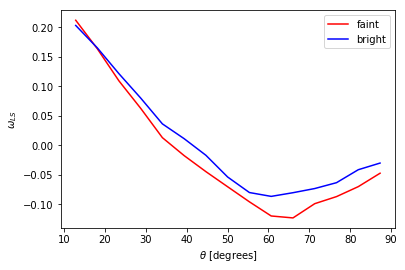

In [9]:
import matplotlib.pyplot as plt

plt.plot(r_cross_f.corr['theta'],r_cross_f.corr['corr'],label='faint',c='r')
plt.plot(r_cross_b.corr['theta'],r_cross_b.corr['corr'],label='bright',c='b')

plt.legend()
plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\omega_{LS}$")
plt.show()